In [2]:
class BNode:
    def __init__(self, t, keys=None, values=None,
                 children=None, is_alive=None):
        self._t = t
        self._keys = keys if keys is not None else []
        self._values = values if values is not None else []
        self._children = children if children is not None else []
        self._is_alive = is_alive if is_alive is not None else []


    def is_ok(self):
        if (self._t >= 2
                and len(self._keys) == len(self._values)
                and len(self._children) in (0, len(self._keys) + 1)
                and len(self._is_alive) == len(self._keys)):
            return True
        else:
            return False


    def dump(self, depth):
        assert self.is_ok(), 'corrupted node'
        print("--------------------")
        for i in range(len(self._keys)):
            print("{0}".format("     " * depth),
                  self._keys[i], self._values[i], self._is_alive[i])
        print("--------------------")
        for child in self._children:
            child.dump(depth + 1)
            
            
    def update_element(self, key, new_value, is_alive):
        for i in range(len(self._keys)):
            if key == self._keys[i]:
                if is_alive:
                    self._values[i] = new_value
                self._is_alive[i] = is_alive
                break


    def is_full(self):
        return True if len(self._keys) == 2*self._t - 1 else False


    def get_key_index(self, key):
        if len(self._keys) == 0:
            return 0
        keys_count = len(self._keys)
        key_index = None

        for i in range(keys_count + 1):
            if i == 0 and key < self._keys[0]:
                key_index = 0
                break
            if (0 < i < keys_count
                  and self._keys[i - 1] < key < self._keys[i]):
                key_index = i
                break
            if (i == keys_count
                  and self._keys[keys_count - 1] < key):
                key_index = keys_count
                break
        return key_index


    def add_element(self, new_key, new_value, is_alive=True):
        key_index = self.get_key_index(new_key)
        if key_index is None:
            self.update_element(new_key, new_value, True)
            return
                
        if len(self._children) > 0 and self._children[key_index].is_full():
            self.split_child(key_index)
            key_index = self.get_key_index(new_key)
            if key_index is None:
                self.update_element(new_key, new_value, True)
                return

        child = None
        if len(self._children) > 0:
            child = self._children[key_index]

        if child is None:
            self._keys.insert(key_index, new_key)
            self._values.insert(key_index, new_value)
            self._is_alive.insert(key_index, is_alive)
        else:
            child.add_element(new_key, new_value, is_alive)


    def delete_element(self, deleting_key):
        deleting_index = self.get_key_index(deleting_key)
        if deleting_index is not None:
            self._children[deleting_index].delete_element(deleting_key)
        else:
            self.update_element(deleting_key, None, False)



    def split_child(self, child_index):
        assert len(self._keys) != 2*self._t - 1,\
                'parent of splitting child is full'
        assert child_index < len(self._children),\
                'incorrect child_index'
        assert self._children[child_index].is_ok(),\
                'a try to split a corrupted child'
        assert len(self._children[child_index]._keys) == 2*self._t - 1,\
                'incorrect number of children'
        assert self._children[child_index].is_full(),\
                'a splitting child is not full'

        child = self._children[child_index]
        left_child = BNode(t=child._t,
                           keys=child._keys[:child._t - 1],
                           values=child._values[:child._t - 1],
                           children=child._children[:child._t],
                           is_alive=child._is_alive[:child._t - 1])
        right_child = BNode(t=child._t,
                            keys=child._keys[child._t:],
                            values=child._values[child._t:],
                            children=child._children[child._t:],
                            is_alive=child._is_alive[child._t:])

        self._keys.insert(child_index, child._keys[child._t - 1])
        self._values.insert(child_index, child._values[child._t - 1])
        self._is_alive.insert(child_index, child._is_alive[child._t - 1])
        self._children[child_index] = left_child
        self._children.insert(child_index + 1, right_child)



class BTree:
    def __init__(self, t):
        self._t = t
        self._root = BNode(t)


    def dump(self):
        self._root.dump(0)


    def is_ok(self):
        return self._root.is_ok()


    def split_root(self):
        assert self._root.is_full(), 'try to split incomplete root'
        left_child = BNode(t=self._t,
                           keys=self._root._keys[:self._t - 1],
                           values=self._root._values[:self._t - 1],
                           children=self._root._children[:self._t],
                           is_alive=self._root._is_alive[:self._t - 1])
        right_child = BNode(t=self._t,
                            keys=self._root._keys[self._t:],
                            values=self._root._values[self._t:],
                            children=self._root._children[self._t:],
                            is_alive=self._root._is_alive[self._t:])
        self._root = BNode(t=self._t,
                           keys=[self._root._keys[self._t - 1]],
                           values=[self._root._values[self._t - 1]],
                           children=[left_child, right_child],
                           is_alive=[self._root._is_alive[self._t - 1]])


    def add_element(self, new_key, new_value, is_alive=True):
        if self._root.is_full():
            self.split_root()
        self._root.add_element(new_key, new_value, is_alive)


    def delete_element(self, deleting_key):
        self._root.delete_element(deleting_key)




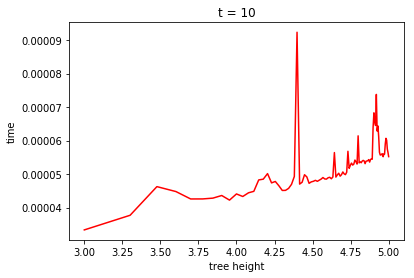

In [6]:
import time
import pylab
import math
import random

t = 10
b_tree = BTree(t)

points_count = 100
add_count = 1000
graph_x_data = []
graph_y_data = []

for i in range(points_count):
    start = time.time()
    for j in range(add_count):
        b_tree.add_element(random.randint(1, 1e6), j)
    end = time.time()
    h = math.log((i + 1)*add_count, t)
    graph_x_data.append(h)
    graph_y_data.append((end - start)/add_count)

pylab.plot(graph_x_data, graph_y_data, 'r')
pylab.xlabel('tree height')
pylab.ylabel('time')
title = 't = ' + str(t)
pylab.title(title)
pylab.show()

In [7]:
t = 2
b_tree = BTree(t)

b_tree.add_element(0, '000')
b_tree.add_element(1, '111')
b_tree.add_element(2, '222')
b_tree.add_element(3, '333')
b_tree.add_element(4, '444')
b_tree.add_element(5, '555')
b_tree.add_element(6, '666')
b_tree.add_element(7, '777')
b_tree.add_element(8, '888')
b_tree.add_element(9, '999')

b_tree.delete_element(8)
b_tree.add_element(8, 'aaa')

b_tree.dump()


--------------------
 3 333 True
--------------------
--------------------
      1 111 True
--------------------
--------------------
           0 000 True
--------------------
--------------------
           2 222 True
--------------------
--------------------
      5 555 True
      7 777 True
--------------------
--------------------
           4 444 True
--------------------
--------------------
           6 666 True
--------------------
--------------------
           8 aaa True
           9 999 True
--------------------
